## Figure 5


before running this code you need to run:

1. lever_centered_maps.ipynb
2. lever_centered_ifr.ipynb


In [1]:
%load_ext autoreload
%autoreload 2
# Change directory
%run ../setup_project.py
%run ../neuronAutopi.py

prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /ext_drives/d80/Jazi_etal_2023/autopi_ca1
Reading /ext_drives/d80/Jazi_etal_2023/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)

Loading: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/myProjectWithTrials.pickle
CPU times: user 5 s, sys: 2.55 s, total: 7.55 s
Wall time: 12.1 s


## Load the data

In [3]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)
    
fn = myProject.dataPath+"/results/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverMaps = pickle.load(handle)
    
fn= myProject.dataPath+"/results/myLeverMapsDissociate.pickle"
with open(fn, 'rb') as handle:
    myLeverMapsDissociate = pickle.load(handle)
    
fn= myProject.dataPath+"/results/myLeverMapsStats.pickle"
with open(fn, 'rb') as handle:
    myLeverMapsStats = pickle.load(handle)

fn= myProject.dataPath+"/results/myLeverMapsDissociateStats.pickle"
with open(fn, 'rb') as handle:
    myLeverMapsDissociateStats = pickle.load(handle)

fn = myProject.dataPath+"/results/myLeverQuadMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverQuadMaps = pickle.load(handle)

fn = myProject.dataPath+"/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

fn = myProject.dataPath+"/results/myAutos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myAutos = pickle.load(handle)
    
fn= myProject.dataPath+"/results/leverMapCor.pickle"
with open(fn, 'rb') as handle:
    leverMapCor = pickle.load(handle)

fn=myProject.dataPath+"/results/leverQuadMapCor.pickle"
with open(fn, 'rb') as handle:
    leverQuadMapCor = pickle.load(handle)

fn= myProject.dataPath+"/results/leverHistoCor.pickle"
with open(fn, 'rb') as handle:
    leverHistoCor = pickle.load(handle)
    
fn=myProject.dataPath+"/results/leverQuadMapRotCor.pickle"
with open(fn, 'rb') as handle:
    leverQuadMapRotCor = pickle.load(handle)
fn=myProject.dataPath+"/results/leverIFRDict.pickle"
with open(fn, 'rb') as handle:
    leverIFR = pickle.load(handle)


## Filter for pyramidal cells

In [4]:
fn=myProject.dataPath+"/results/cell_classification_noint.csv"
ct= pd.read_csv(fn)

if ct.shape[0]!=myMaps["circ80"].shape[0]:
    print("problem with length of cell_classification.csv")

In [5]:
pyrIndices=ct.cellType=="pyr"
pyrId=ct.id[ct.cellType=="pyr"]
print("Pyramidal cells: {}".format(np.sum(ct.cellType=="pyr")))


Pyramidal cells: 438


In [6]:
for k in myMaps.keys():
    myMaps[k] = myMaps[k][pyrIndices]

In [7]:
for d in [myLeverMaps,myLeverMapsDissociate,myLeverMapsStats,myLeverMapsDissociateStats]:
    for k in d.keys():
        for kk in d[k].keys():
            for kkk in d[k][kk].keys():
                d[k][kk][kkk] = d[k][kk][kkk][pyrIndices]

In [8]:
for lc in  myLeverQuadMaps.keys():
    for k in myLeverQuadMaps[lc].keys():
        myLeverQuadMaps[lc][k] = myLeverQuadMaps[lc][k][pyrIndices] 

In [9]:
for k in myLeverHistos[0].keys():
    for i in [0,1]:
        myLeverHistos[i][k]=myLeverHistos[i][k][pyrIndices] # rate arrays, occupancy arrays

for k in myLeverHistos[0].keys():
        myLeverHistos[3][k]=myLeverHistos[3][k][pyrIndices] # threshold for peak rate
        
        

In [10]:
nCond = int(len(leverMapCor.r)/len(ct.cellType))
leverMapCor["cellId"] = np.concatenate([ct.id.to_numpy()]*nCond) # 
leverMapCor = leverMapCor[leverMapCor.cellId.isin(pyrId)]

In [11]:
nCond = len(leverHistoCor.condition.unique())
leverHistoCor["cellId"] = np.concatenate([ct.id.to_numpy()]*nCond) # 
leverHistoCor = leverHistoCor[leverHistoCor.cellId.isin(pyrId)]

In [12]:
nCond = int(len(leverQuadMapCor.r)/ct.shape[0])
leverQuadMapCor["cellId"] = np.concatenate([ct.id.to_numpy()]*nCond) # 
leverQuadMapCor = leverQuadMapCor[leverQuadMapCor.cellId.isin(pyrId)]


In [13]:
for k in leverQuadMapRotCor.keys():
    for kk in leverQuadMapRotCor[k].keys():
        leverQuadMapRotCor[k][kk] = leverQuadMapRotCor[k][kk][pyrIndices,:]

In [14]:
for k in myAutos.keys():
    myAutos[k]["auto"]= myAutos[k]["auto"][pyrIndices]


In [15]:
pyrId = pyrId.reset_index(drop=True)

## Identify cells with lever-anchored fields

It is always good to identify a group of cells having the properties we are interested into.

Because there is remapping between light and dark trials, and we did different rotations of the lever centered data (lever, bridge, none), we will do the detection of lever anchored cells for different conditions separately. 
* lever-anchored light-none
* lever-anchored light-lever
* lever-anchored light-bridge
* lever-anchored dark-none
* lever-anchored dark-lever
* lever-anchored dark-bridge

Detection thresholds:

* Rate peak in the rate-distance map is within 10 cm of the lever and is significantly above shuffling distribution
* Peak rate in the lever map > 7.5 Hz
* Correlation between 2 independent sets of trials > 0.4


In [16]:
# max in lever maps for each neuron
rateType="map"
peakRate={}
for k in myLeverMaps[rateType].keys():
    peakRate[k] = {}
    for kk in myLeverMaps[rateType][k].keys():
        #print(k,kk)
        peakRate[k][kk] = np.nanmax(myLeverMaps[rateType][k][kk],axis=(1,2))

# correlations between 2 sets of trials
df = leverMapCor[leverMapCor.condition.isin(["l1l2","d1d2"])]

In [17]:
# peak rate location for each neuron
peakLoc={}
peakHistoSignificance={}
for cond in ["all_light","all_dark"]:
    peakLoc[cond] = myLeverHistos[2][np.argmax(myLeverHistos[0][cond],axis=1)]
    peakHistoSignificance[cond] = np.nanmax(myLeverHistos[0][cond],axis=1) > myLeverHistos[3][cond]

/tmp/ipykernel_1924616/234938853.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfm=dfpeaklock.groupby(['subject']).median().reset_index()


[Text(0, 0, 'peakRateDark'), Text(1, 0, 'peakRateLight')]

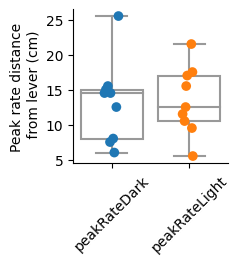

In [18]:
dfpeaklock=pd.DataFrame({'peakRateDark': peakLoc["all_dark"], 'peakRateLight':peakLoc["all_light"],'cid':pyrId})
dfpeaklock['subject']= [cid.split('-')[0] for cid in dfpeaklock.cid]
###########
## Group the df based on mouse
##########
dfm=dfpeaklock.groupby(['subject']).median().reset_index()
#################
## plot the change in peak rate per mcie
##################
fig=plt.figure(figsize=(2,2))
sns.boxplot(dfm, color='w')
sns.stripplot(dfm,size=7)
ax= fig.gca()
ax.set_ylabel('Peak rate distance\n from lever (cm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(labels= ['peakRateDark','peakRateLight'],rotation=45)

/tmp/ipykernel_1924616/594486429.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resLocDist = resLocDist.append(pd.DataFrame({"light":"light",


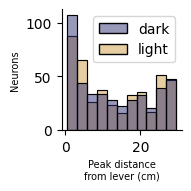

In [19]:
resLocDist = pd.DataFrame({"light":"dark",
             "peakLoc":peakLoc["all_dark"]})
resLocDist = resLocDist.append(pd.DataFrame({"light":"light",
             "peakLoc":peakLoc["all_light"]}))
resLocDist = resLocDist.reset_index()

## standard plot config

col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
setFigureFontSizes()
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

def peakDistributionPlot(gs):
    ax = fig.add_subplot(gs[0])
    g = sns.histplot(x="peakLoc",hue="light",data=resLocDist,palette=darkLightColors(),ax=ax)
    g.legend_.set_title("")
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Peak distance\nfrom lever (cm)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

peakDistributionPlot(gs)

Is this significantly different from chance level where every value between 0-30 is as likely?

In [20]:
nCells=len(pyrId)
maxVal=30
nBins=11
maxDark = np.max(np.histogram(peakLoc["all_dark"],bins=nBins)[0])
maxLight = np.max(np.histogram(peakLoc["all_light"],bins=nBins)[0])
print(maxDark,maxLight)

107 88


60.0

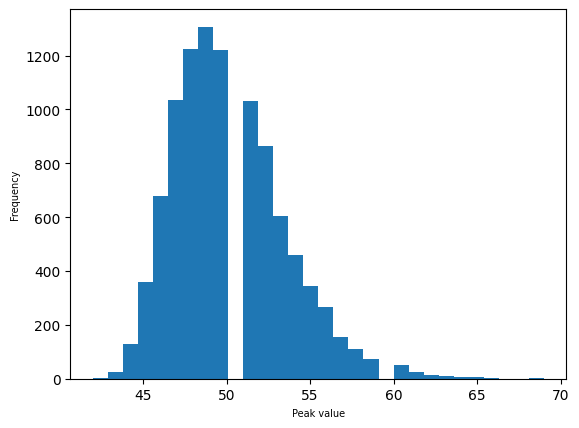

In [22]:
nIter=10000
res = np.empty(nIter)
for i in range(nIter):
    s = np.random.random_sample(nCells)*30
    res[i] = np.max(np.histogram(s,bins=nBins)[0])
plt.hist(res,bins=30)
plt.ylabel("Frequency")
plt.xlabel("Peak value")
np.quantile(res,.99)

The observed peaks for light and dark trials are above chance levels.

For each threshold, we get a 1 or 0.
We have 3 thresholds per cell *light*  and rotation combination

In [23]:
from scipy import stats

maxDistance= 10
thresholdDict = {}
for light in ["all_light","all_dark"]:
    thresholdDict[light] = {}
    if light == "all_light":
        comb = "l1l2"
    elif light == "all_dark":
        comb = "d1d2"
    else:
        print("problem with condition")
        
    for rotType in ["none","lever","bridge"]:
        thresholdDict[light][rotType] = np.zeros((len(pyrId),3))
        thresholdDict[light][rotType][:,0] = peakRate[light][rotType] > 7.5
        thresholdDict[light][rotType][:,1] = leverMapCor.r[(leverMapCor.condition==comb)&(leverMapCor.rotation==rotType)]>0.4
        thresholdDict[light][rotType][:,2] = (peakLoc[light]<maxDistance) & (peakHistoSignificance[cond]) # 10
print(thresholdDict.keys())
print(thresholdDict["all_light"].keys())
print(thresholdDict["all_light"]["none"].shape)


dict_keys(['all_light', 'all_dark'])
dict_keys(['none', 'lever', 'bridge'])
(438, 3)


In [24]:
leverCells={}
for light in ["all_light","all_dark"]:
    leverCells[light]={}
    for rotType in ["none","lever","bridge"]:
        indices = np.sum(thresholdDict[light][rotType],axis=1)==3 # 3 means the cell satisfied the 3 criteria
        leverCells[light][rotType] = pd.DataFrame({"id": pyrId[indices],
                                    "cellIndex": np.arange(len(pyrId))[indices]})

In [25]:
for light in ["all_light","all_dark"]:
    m = np.zeros((len(pyrId),3))
    for i,rotType in enumerate(["none","lever","bridge"]):
        m[:,i] = np.sum(thresholdDict[light][rotType],axis=1)==3
    indices = np.sum(m,axis=1)>0
    leverCells[light]["any"] = pd.DataFrame({"id": pyrId[indices],
                                 "cellIndex": np.arange(len(pyrId))[indices]})
    indices = np.sum(m,axis=1)==3
    leverCells[light]["all"] = pd.DataFrame({"id": pyrId[indices],
                                 "cellIndex": np.arange(len(pyrId))[indices]})
    

In [26]:
nCells=len(pyrId)
resSign = pd.DataFrame()
for light in ["dark","light"]:
    for rotType in ["none","lever","bridge"]:
        resSign = resSign.append(pd.DataFrame({"light":[light],
                                      "rotation": rotType,
                                      "sign": len(leverCells["all_"+light][rotType].cellIndex),
                                      "total": nCells}))
resSign["percent"] = resSign.sign/resSign.total*100
resSign["nonSign"] = resSign.total-resSign.sign
resSign = resSign.reset_index()


/tmp/ipykernel_1924616/3629462821.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resSign = resSign.append(pd.DataFrame({"light":[light],
/tmp/ipykernel_1924616/3629462821.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resSign = resSign.append(pd.DataFrame({"light":[light],
/tmp/ipykernel_1924616/3629462821.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resSign = resSign.append(pd.DataFrame({"light":[light],
/tmp/ipykernel_1924616/3629462821.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resSign = resSign.append(pd.DataFrame({"light":[light],


In [27]:
resSign

,index,light,rotation,sign,total,percent,nonSign
0,0,dark,none,109,438,24.885845,329
1,0,dark,lever,50,438,11.415525,388
2,0,dark,bridge,110,438,25.114155,328
3,0,light,none,106,438,24.200913,332
4,0,light,lever,50,438,11.415525,388
5,0,light,bridge,102,438,23.287671,336


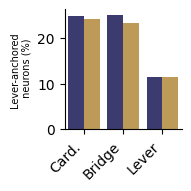

In [28]:
col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

def percentLeverAnchoredFields(gs,showLegend=True):
    
    myDict={"xTicksValues": ["Card.","Bridge","Lever"]
           }

    ax = fig.add_subplot(gs[0])
    sns.barplot(x="rotation",y="percent",hue="light",data=resSign,order=["none","bridge","lever"],palette=darkLightColors())

    ax.set_ylabel("Lever-anchored\n neurons (%)")
    ax.set_xlabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(myDict["xTicksValues"], rotation= 45,ha = "right")
    if showLegend:
        ax.legend(loc=0, frameon=False)
    else:
        ax.legend([],[],frameon=False)
percentLeverAnchoredFields(gs,showLegend=False)

## Calculate the levercells based on rotType per mcie

In [29]:
for light in ["all_dark","all_light"]:
    for rotType in ["none","lever","bridge"]:
        leverCells[light][rotType]['subject']=  [cid.split('-')[0] for cid in leverCells[light][rotType].id]

In [30]:
LC = resSign.sign[(resSign.light=="light")&(resSign.rotation=="none")].values[0],resSign.nonSign[(resSign.light=="light")&(resSign.rotation=="none")].values[0]
DC = resSign.sign[(resSign.light=="dark")&(resSign.rotation=="none")].values[0],resSign.nonSign[(resSign.light=="dark")&(resSign.rotation=="none")].values[0]

LB = resSign.sign[(resSign.light=="light")&(resSign.rotation=="bridge")].values[0],resSign.nonSign[(resSign.light=="light")&(resSign.rotation=="bridge")].values[0]
DB = resSign.sign[(resSign.light=="dark")&(resSign.rotation=="bridge")].values[0],resSign.nonSign[(resSign.light=="dark")&(resSign.rotation=="bridge")].values[0]

LL = resSign.sign[(resSign.light=="light")&(resSign.rotation=="lever")].values[0],resSign.nonSign[(resSign.light=="light")&(resSign.rotation=="lever")].values[0]
DL = resSign.sign[(resSign.light=="dark")&(resSign.rotation=="lever")].values[0],resSign.nonSign[(resSign.light=="dark")&(resSign.rotation=="lever")].values[0]

print(LC,DC,LB,DB,LL,DL)

###################################
### Print the stats 
###################################

from scipy.stats import chisquare

print("chi-square Cardinal / light-dark")
print(chisquare(f_obs = LC, f_exp= DC))
print("chi-square Bridge / light-dark")
print(chisquare(f_obs = LB, f_exp= DB))
print("chi-square Lever / light-dark")
print(chisquare(f_obs = LL, f_exp= DL))
print()

print("chi-square light Cardian-Lever")
print(chisquare(f_obs = LC, f_exp= LL))
print("chi-square dark Cardian-Lever")
print(chisquare(f_obs = DC, f_exp= DL))
print()
print("chi-square light Bridge-Lever")
print(chisquare(f_obs = LB, f_exp= LL))
print("chi-square dark Bridge-Lever")
print(chisquare(f_obs = DB, f_exp= DL))

print()
print("chi-square light Cardinal-Bridge")
print(chisquare(f_obs = LC, f_exp= LB))
print("chi-square dark Cardinal-Bridge")
print(chisquare(f_obs = DC, f_exp= DB))

(106, 332) (109, 329) (102, 336) (110, 328) (50, 388) (50, 388)
chi-square Cardinal / light-dark
Power_divergenceResult(statistic=0.1099244304397535, pvalue=0.7402301870649919)
chi-square Bridge / light-dark
Power_divergenceResult(statistic=0.7769401330376939, pvalue=0.37807859253214937)
chi-square Lever / light-dark
Power_divergenceResult(statistic=0.0, pvalue=1.0)

chi-square light Cardian-Lever
Power_divergenceResult(statistic=70.80247422680412, pvalue=3.9484157080511115e-17)
chi-square dark Cardian-Lever
Power_divergenceResult(statistic=78.59164948453609, pvalue=7.637156631113155e-19)

chi-square light Bridge-Lever
Power_divergenceResult(statistic=61.049072164948456, pvalue=5.566974941438324e-15)
chi-square dark Bridge-Lever
Power_divergenceResult(statistic=81.27835051546391, pvalue=1.960626757312645e-19)

chi-square light Cardinal-Bridge
Power_divergenceResult(statistic=0.20448179271708683, pvalue=0.6511273353064817)
chi-square dark Cardinal-Bridge
Power_divergenceResult(statistic

## What is the distribution of preferred direction for the lever-anchored fields?

We get the mean direction of the angular firing rate maps around the lever.

In [31]:
resMeanDir = pd.DataFrame()
for rotType in ["none","bridge","lever"]:
    for light in ["dark","light"]:
        indices = leverCells["all_"+light][rotType].cellIndex
        #myLeverMapsStats columns: mean_direction_rad, mean_direction_deg, mean_vector_length, peak_angle_rad, peak_rate
        meanDirection = myLeverMapsStats["angular"]["all_"+light][rotType][indices,0]
        resMeanDir = resMeanDir.append(pd.DataFrame({"light":light,
                                      "rotation":rotType,
                                      "meanDirection": meanDirection}))
resMeanDir = resMeanDir.reset_index()

#######################
## Get the stats and the number of LeverCell based on rotation 
####################

from  astropy.stats import rayleightest
for rotType in ["none","bridge","lever"]:
    for light in ["dark","light"]:
        print(rotType, light, "p-value:",rayleightest(resMeanDir.meanDirection[(resMeanDir.light==light)&(resMeanDir.rotation==rotType)]), "n:",
              len(resMeanDir.meanDirection[(resMeanDir.light==light)&(resMeanDir.rotation==rotType)]) )

/tmp/ipykernel_1924616/3881221735.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resMeanDir = resMeanDir.append(pd.DataFrame({"light":light,
/tmp/ipykernel_1924616/3881221735.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resMeanDir = resMeanDir.append(pd.DataFrame({"light":light,
/tmp/ipykernel_1924616/3881221735.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resMeanDir = resMeanDir.append(pd.DataFrame({"light":light,
/tmp/ipykernel_1924616/3881221735.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resMeanDir = resMeanDir.append(pd.DataFrame({"light":light,


none dark p-value: 0.7618960807272332 n: 109
none light p-value: 0.20568385883891932 n: 106
bridge dark p-value: 0.9592892663421513 n: 110
bridge light p-value: 0.20137651390744826 n: 102
lever dark p-value: 0.9363910463727954 n: 50
lever light p-value: 0.3565047533711564 n: 50


### plot with the distribution of mean directions

The distribution of mean direction are not significantly different from a a uniform distribution.

## Summary so far

We can now plot our 2x2 figure summary.

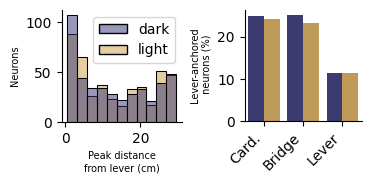

In [32]:
col=2
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(3, 2, figure=fig,height_ratios=[0.1,1,1])

gsDist = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,0])
peakDistributionPlot(gsDist)
gsSign = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,1])
percentLeverAnchoredFields(gsSign,showLegend=False)

ax.axis("off")
plt.show()

In [33]:
fn = myProject.dataPath+"/results/leverCells.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(leverCells, handle)

saving: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/leverCells.pickle


## Spatial coding in 3 different reference frames

We want to know in which reference frames spatial coding is the best.

We can look at correlation between 2 sets of independent trials. We can limit the analysis to the selected neurons or use all neurons.

In [34]:
df = leverMapCor[(leverMapCor.condition.isin(["l1l2","d1d2"]))]
df.condition[df.condition=="l1l2"]="Light"
df.condition[df.condition=="d1d2"]="Dark"
df.rotation[df.rotation=="lever"] = "Lever"
df.rotation[df.rotation=="bridge"] = "Bridge"
df.rotation[df.rotation=="none"] = "Card."
dfMapCor = df
dfMapCor.rename(columns = {'condition':'light'}, inplace = True)
dfMapCor

,rotation,light,r,cellId
2,Lever,Light,0.062687,mn5824-20112020-0107_92
5,Lever,Light,-0.187159,mn5824-20112020-0107_100
6,Lever,Light,0.197228,mn5824-20112020-0107_114
7,Lever,Light,-0.182077,mn5824-20112020-0107_116
8,Lever,Light,-0.168927,mn5824-20112020-0107_118
...,...,...,...,...
1056,Card.,Dark,0.373372,mn9686-01112021-0106_79
1057,Card.,Dark,0.431625,mn9686-01112021-0106_81
1068,Card.,Dark,0.700497,mn9686-01112021-0106_197
1078,Card.,Dark,0.770001,mn9686-01112021-0106_242


We need to do stats on this.

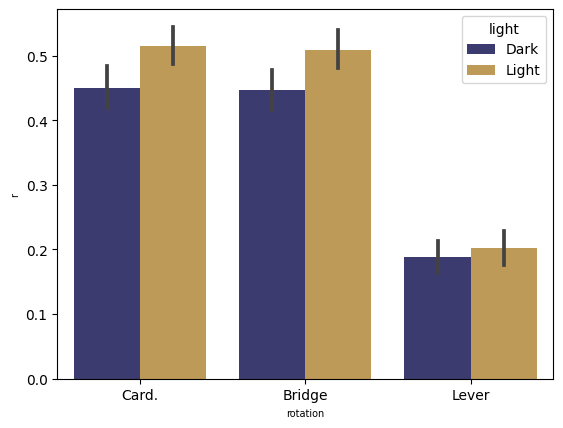

                          sum_sq      df           F        PR(>F)
C(light)                1.393995     1.0   14.850771  1.192062e-04
C(rotation)            46.462226     2.0  247.490162  4.953974e-99
C(light):C(rotation)    0.356832     2.0    1.900735  1.496685e-01
Residual              241.519315  2573.0         NaN           NaN
                  coef   std err          t         P>|t|  Conf. Int. Low  \
Card.-Bridge  0.003520  0.020919   0.168269  8.663851e-01       -0.037500   
Lever-Bridge -0.258016  0.020919 -12.333991  5.322646e-34       -0.299036   
Lever-Card.  -0.261536  0.020919 -12.502260  7.319334e-35       -0.302556   

              Conf. Int. Upp.     pvalue-sh  reject-sh  
Card.-Bridge         0.044540  8.663851e-01      False  
Lever-Bridge        -0.216996  1.064529e-33       True  
Lever-Card.         -0.220516  2.195800e-34       True  
                coef   std err         t     P>|t|  Conf. Int. Low  \
Light-Dark  0.062116  0.020895  2.972817  0.002978        

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.barplot(hue = "light", y = "r", x = "rotation", data = dfMapCor,order = ["Card.","Bridge","Lever"],hue_order=["Dark","Light"],palette=darkLightColors())
plt.show()

#perform two-way ANOVA
model = ols('r ~ C(light) + C(rotation) + C(light):C(rotation)', data=dfMapCor).fit()
print(sm.stats.anova_lm(model, typ=2))

# significant light and significant rotation main effect
pw = model.t_test_pairwise("C(rotation)",method="sh")
print(pw.result_frame)

pw = model.t_test_pairwise("C(light)",method="sh")
print(pw.result_frame)


In [36]:
df = pd.DataFrame()
myDict={"conditionName":{"light":"l1l2",
                        "dark":"d1d2"},
       "rotationName":{"none":"Card.",
                      "bridge":"Bridge",
                      "lever":"Lever"},
       "lightName":{"light":"Light",
                   "dark":"Dark"}}
for light in ["light","dark"]:
       for rotType in ["lever","bridge","none"]:
            cluIds = leverCells["all_"+light][rotType].id
            indices = (leverMapCor.condition==myDict["conditionName"][light])&(leverMapCor.rotation==rotType)&(leverMapCor.cellId.isin(cluIds))
            rVal = leverMapCor[indices].r
            df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
                                        "rotation": myDict["rotationName"][rotType],
                                        "r": rVal}))


/tmp/ipykernel_1924616/3176531194.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/3176531194.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/3176531194.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/3176531194.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/3176531194.py

This plot shows that there was a threshold of 0.4 when selecting the lever cells.

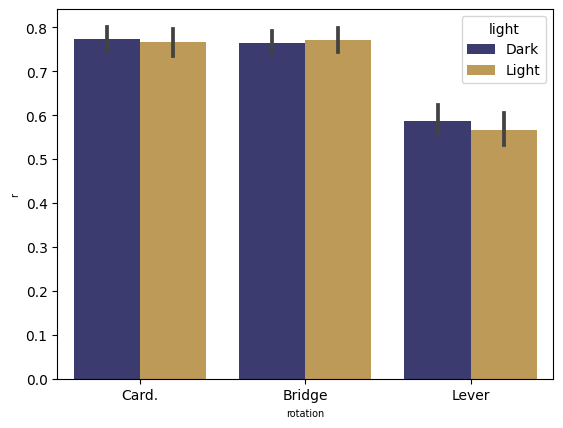

                         sum_sq     df          F        PR(>F)
C(light)               0.001137    1.0   0.053526  8.171286e-01
C(rotation)            2.965679    2.0  69.830075  1.354968e-27
C(light):C(rotation)   0.013007    2.0   0.306259  7.363286e-01
Residual              11.063417  521.0        NaN           NaN
                  coef   std err         t         P>|t|  Conf. Int. Low  \
Card.-Bridge  0.008724  0.019694  0.442982  6.579623e-01       -0.029966   
Lever-Bridge -0.176463  0.024854 -7.099841  4.112464e-12       -0.225290   
Lever-Card.  -0.185187  0.024890 -7.440194  4.175934e-13       -0.234084   

              Conf. Int. Upp.     pvalue-sh  reject-sh  
Card.-Bridge         0.047414  6.579623e-01      False  
Lever-Bridge        -0.127635  8.224928e-12       True  
Lever-Card.         -0.136290  1.252780e-12       True  
               coef   std err        t     P>|t|  Conf. Int. Low  \
Light-Dark  0.00725  0.020031  0.36193  0.717551       -0.032101   

          

In [37]:
sns.barplot(hue = "light", y = "r", x = "rotation", data = df,order = ["Card.","Bridge","Lever"],hue_order=["Dark","Light"],palette=darkLightColors())
plt.show()

#perform two-way ANOVA
model = ols('r ~ C(light) + C(rotation) + C(light):C(rotation)', data=df).fit()
print(sm.stats.anova_lm(model, typ=2))

# significant light and significant rotation main effect
pw = model.t_test_pairwise("C(rotation)",method="sh")
print(pw.result_frame)

pw = model.t_test_pairwise("C(light)",method="sh")
print(pw.result_frame)


## Mean vector length in different rotation types at the lever

We can do a similar analysis but with the mean vector length instead of correlations. 

First using all pyramidal cells.

In [38]:
res = []
for light in ["all_light","all_dark"]:
    for ref in ["lever","bridge","none"]:
        res.append(pd.DataFrame({"cellId" : pyrId, 
                                 "rotation" : ref,
                                 "light": light,
                                 "vl": myLeverMapsStats["angular"][light][ref][:,2]}))
dfMvl = pd.concat(res)


dfMvl.light[dfMvl.light=="all_light"]="Light"
dfMvl.light[dfMvl.light=="all_dark"]="Dark"
dfMvl.rotation[dfMvl.rotation=="lever"] = "Lever"
dfMvl.rotation[dfMvl.rotation=="bridge"] = "Bridge"
dfMvl.rotation[dfMvl.rotation=="none"] = "Card."



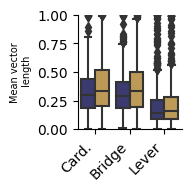

In [39]:
def plotMapMvl(gs,dfMapMvl, showLegend=False):
    ax = fig.add_subplot(gs[0])
    
    sns.boxplot(x="rotation", y="vl", hue = "light", data=dfMapMvl, order = ["Card.", "Bridge", "Lever"],hue_order=["Dark","Light"],palette=darkLightColors(),dodge=True)
    ax.set_ylabel("Mean vector\n length")
    ax.set_xlabel("")
    ax.set_xticklabels(["Card.", "Bridge", "Lever"],rotation= 45,ha = "right")
    if showLegend:
        ax.legend(title="",loc="lower left")
    else :
        ax.legend([],[],frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,1)

col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig)
plotMapMvl(gs,dfMvl)

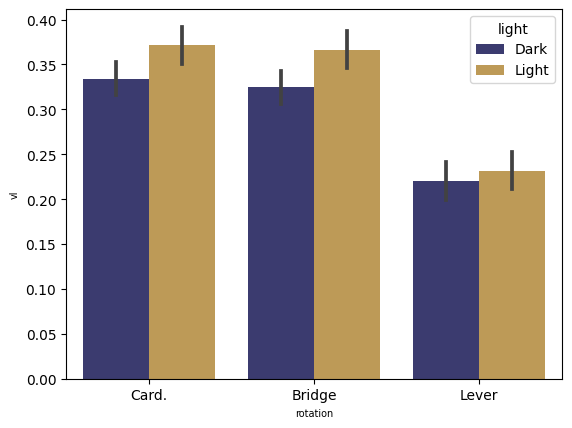

                          sum_sq      df          F        PR(>F)
C(light)                0.583490     1.0  12.999180  3.176123e-04
C(rotation)             8.721347     2.0  97.148512  2.194563e-41
C(light):C(rotation)    0.114082     2.0   1.270782  2.807901e-01
Residual              114.281472  2546.0        NaN           NaN
                  coef   std err         t         P>|t|  Conf. Int. Low  \
Card.-Bridge  0.009021  0.014568  0.619232  5.358187e-01       -0.019546   
Lever-Bridge -0.105195  0.014577 -7.216663  6.998881e-13       -0.133779   
Lever-Card.  -0.114217  0.014577 -7.835529  6.800534e-15       -0.142800   

              Conf. Int. Upp.     pvalue-sh  reject-sh  
Card.-Bridge         0.037588  5.358187e-01      False  
Lever-Bridge        -0.076612  1.399776e-12       True  
Lever-Card.         -0.085633  2.040160e-14       True  
                coef   std err         t     P>|t|  Conf. Int. Low  \
Light-Dark  0.041325  0.014526  2.844978  0.004477        0.012842 

In [40]:
sns.barplot(hue = "light", y = "vl", x = "rotation", data = dfMvl,order = ["Card.","Bridge","Lever"],hue_order=["Dark","Light"],palette=darkLightColors())
plt.show()

#perform two-way ANOVA
model = ols('vl ~ C(light) + C(rotation) + C(light):C(rotation)', data=dfMvl).fit()
print(sm.stats.anova_lm(model, typ=2))

# significant light and significant rotation main effect
pw = model.t_test_pairwise("C(rotation)",method="sh")
print(pw.result_frame)

pw = model.t_test_pairwise("C(light)",method="sh")
print(pw.result_frame)

Now only with the lever cells

In [41]:
leverCells["all_light"]["none"].shape, leverCells["all_dark"]["none"].shape,leverCells["all_light"]["bridge"].shape,

((106, 3), (109, 3), (102, 3))

In [42]:
df = pd.DataFrame()
myDict={"conditionName":{"light":"all_light",
                        "dark":"all_dark"},
       "rotationName":{"none":"Card.",
                      "bridge":"Bridge",
                      "lever":"Lever"},
       "lightName":{"light":"Light",
                   "dark":"Dark"}}
for light in ["light","dark"]:
       for rotType in ["lever","bridge","none"]:
            
            cluIndices = leverCells["all_"+light][rotType].cellIndex
            
            mvl = myLeverMapsStats["angular"][myDict["conditionName"][light]][rotType][cluIndices,2]
            
            df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
                                        "rotation": myDict["rotationName"][rotType],
                                        "vl": mvl}))
dfMvlSel = df

/tmp/ipykernel_1924616/760029939.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/760029939.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/760029939.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],
/tmp/ipykernel_1924616/760029939.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"light":myDict["lightName"][light],


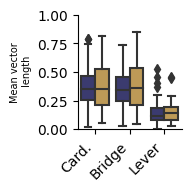

In [43]:
col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig)
plotMapMvl(gs,dfMvlSel)

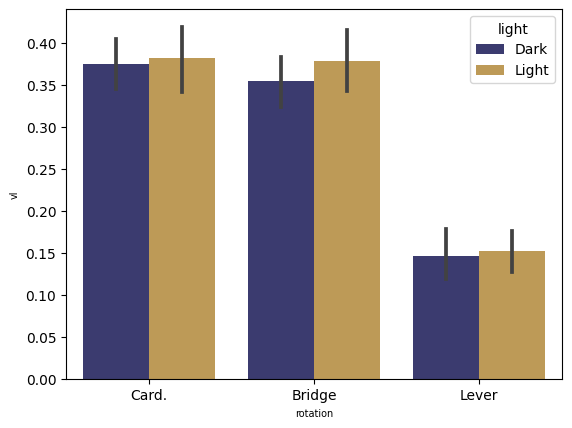

                         sum_sq     df          F        PR(>F)
C(light)               0.024887    1.0   0.878854  3.489500e-01
C(rotation)            4.040112    2.0  71.337252  4.139183e-28
C(light):C(rotation)   0.010544    2.0   0.186181  8.301784e-01
Residual              14.753148  521.0        NaN           NaN
                  coef   std err         t         P>|t|  Conf. Int. Low  \
Card.-Bridge  0.020603  0.022742  0.905926  3.653940e-01       -0.024075   
Lever-Bridge -0.207413  0.028701 -7.226590  1.771845e-12       -0.263797   
Lever-Card.  -0.228016  0.028742 -7.933064  1.315204e-14       -0.284481   

              Conf. Int. Upp.     pvalue-sh  reject-sh  
Card.-Bridge         0.065281  3.653940e-01      False  
Lever-Bridge        -0.151028  3.543689e-12       True  
Lever-Card.         -0.171550  3.945611e-14       True  
                coef   std err         t     P>|t|  Conf. Int. Low  \
Light-Dark  0.024642  0.023131  1.065339  0.287216       -0.020799   

      

In [44]:
sns.barplot(hue = "light", y = "vl", x = "rotation", data = dfMvlSel,order = ["Card.","Bridge","Lever"],hue_order=["Dark","Light"],palette=darkLightColors())
plt.show()

#perform two-way ANOVA
model = ols('vl ~ C(light) + C(rotation) + C(light):C(rotation)', data=dfMvlSel).fit()
print(sm.stats.anova_lm(model, typ=2))

# significant light and significant rotation main effect
pw = model.t_test_pairwise("C(rotation)",method="sh")
print(pw.result_frame)

pw = model.t_test_pairwise("C(light)",method="sh")
print(pw.result_frame)

# Summary of stats so far

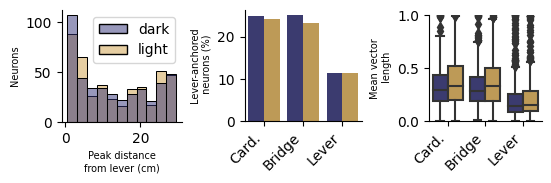

In [47]:
col=3
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(3, 3, figure=fig,height_ratios=[0.1,1,1])

gsDist = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,0])
peakDistributionPlot(gsDist)
gsSign = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,1])
percentLeverAnchoredFields(gsSign,showLegend=False)

gsMvl = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,2])
plotMapMvl(gsMvl,dfMvl)


ax.axis("off")
plt.show()

fn= "/home/maryam/Desktop/Ca1_final/fig5/fig5e-f.pdf"
fig.savefig(fn, dpi= 300)

## Put Cardinal and Bridge reference frames against each other

Now everyone wonders which one of cardinal or bridge is the best reference frame.

We can compare them in a within cell comparison.

In [48]:
from scipy.stats import wilcoxon,ttest_rel

myDict = {"lightNames":{"Light":"all_light",
                          "Dark":"all_dark"},
         "rotNames":{"Card.":"none",
                    "Bridge":"bridge",
                    "Lever": "lever"}}

cardBri = pd.DataFrame()

for light in ["Light", "Dark"]:
    
    df = dfMvl[(dfMvl.light == light)&(dfMvl.cellId.isin(leverCells[myDict["lightNames"][light]]["any"].id))]
    n = len(df[df.rotation=="Card."].vl)
    statistic, pval = ttest_rel(df[df.rotation=="Card."].vl, df[df.rotation=="Bridge"].vl)
    print(light, statistic, pval,n)
    myDiff = df[df.rotation=="Card."].vl - df[df.rotation=="Bridge"].vl
    cardBri = cardBri.append(pd.DataFrame({"light": light,
                                           "vlDiff": myDiff}))

cardBri = cardBri.reset_index()
cardBri

Light 3.0647767038658773 0.0027297934424274405 113
Dark 4.929741323523279 2.820520314795593e-06 115


/tmp/ipykernel_1924616/758895857.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cardBri = cardBri.append(pd.DataFrame({"light": light,
/tmp/ipykernel_1924616/758895857.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cardBri = cardBri.append(pd.DataFrame({"light": light,


,index,light,vlDiff
0,0,Light,0.029247
1,13,Light,-0.030169
2,16,Light,0.032394
3,27,Light,-0.012090
4,29,Light,-0.036882
...,...,...,...
223,421,Dark,0.005047
224,422,Dark,-0.059267
225,432,Dark,-0.038204
226,435,Dark,-0.025742


In [49]:
def formatPValue(p,withE=True):
    """
    Format the p value to print on a plot
    It will format use latex to format P = 1.2 x 10-20 with -20 as supercript and P in italic.
    You can pass the returned value to ax.text().
    
    Argument:
    p: p-value
    withE: boolean, indicate whether to print in the 1.23e-10 format
    
    Example
    ax.text(1,1, formatPValue(p))
    
    
    """
    if p > 0.001:
        pString = "$P$ = {:.2}".format(p)
    else:
        if withE:
            pString = "$P$ = {:.2e}".format(p)
        else:
            sciNoti = "{:.1e}".format(p)
            base = sciNoti.split("e")[0]
            expo = sciNoti.split("e")[1]
            pString = "$P$ = {} x $10^{{{}}}$".format(base,expo)
    return pString

def plotCardBridgeDiff(gs,cardBri, showLegend=False):
    """
    We will plot light and dark on different plots
    """
    
    for i, light in enumerate(["Dark","Light"]):
        ax = fig.add_subplot(gs[i])
        #ax.set_title(light.capitalize())
        

        sns.histplot(data=cardBri[cardBri.light==light],x="vlDiff",color=darkLightColors()[i])
        
        w, p = wilcoxon(cardBri[cardBri.light==light].vlDiff)
        n = len(cardBri[cardBri.light==light].vlDiff)
        print(light,p,n)
        ax.plot([0,0],[0,24],color="black", linestyle="--")
        ax.set_ylabel("Neurons")
        ax.set_xlabel("MVL (Card. - Bridge)")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(-0.15,0.15)
        ax.set_ylim(0,28)
        ax.text(-0.1,25, formatPValue(p))
        ax.xaxis.set_label_coords(.45, -.2)


Dark 4.357000711820951e-06 115
Light 0.003096904604016111 113


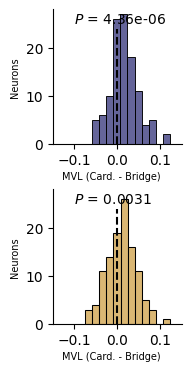

In [50]:
col=1
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, figure=fig)
plotCardBridgeDiff(gs,cardBri)



Summary so far of the stats

Dark 4.357000711820951e-06 115
Light 0.003096904604016111 113


(-0.5, 1.5, 4.5, 26.5)

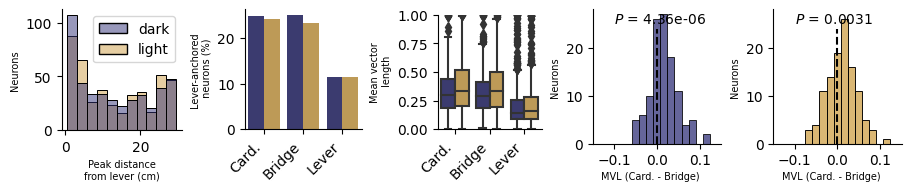

In [51]:
col=5
row=3
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(3, col, figure=fig)

gsDist = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,0])
peakDistributionPlot(gsDist)
gsSign = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,1])
percentLeverAnchoredFields(gsSign,showLegend=False)

gsMvl = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,2])
plotMapMvl(gsMvl,dfMvl)

gsDiff = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,3:])
plotCardBridgeDiff(gsDiff,cardBri)



ax.axis("off")


This figure is more informative than the previous one as it shows how many cells are lever-locked and the distribution of fields around the lever.

We need a scheme to explain what is the difference between Cardinal, Bridge and Lever reference frames. 
I prepared a figure in Inkscape that we can load using matplotlib.


/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/cardinal.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/bridge.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/lever.png


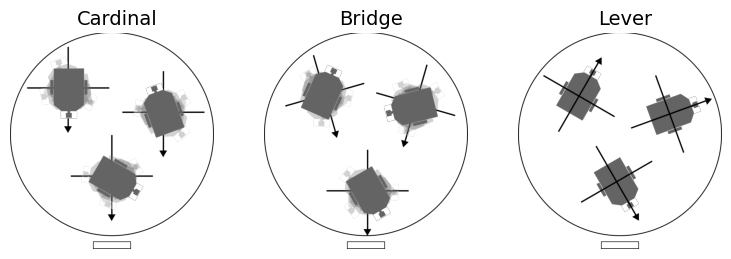

In [52]:
import matplotlib.image as img
  
    
col=4
row=1.75
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig)

def plotSchematic(gs):

    gs = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec= gs[0],height_ratios=[0.1,1],width_ratios=[2,0.4,2,0.4,2])

    for i, name in enumerate(["cardinal","bridge","lever"]):

        #gsTitle = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,i*2+1])
        #ax = fig.add_subplot(gsTitle[0])


        gsSch = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,i*2])
        ax = fig.add_subplot(gsSch[0])

        # reading png image file
        fn="/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/{}.png".format(name)
        print(fn)
        im = img.imread(fn)
        # show image
        ax.imshow(im)
        ax.axis('off')
        ax.text(500,-40,name.capitalize(),fontsize=14,horizontalalignment='center')
        ax.axis('off')
    
plotSchematic(gs)

# NEXT

We need to show that the maps are the same across quadrants

## Plotting functions that can be used to make the figures

In [53]:
def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY)
    ax.axis('off')
def plotAuto(ax,rate,time,title=""):
    ax.plot(time,rate)
    ax.set_ylim(0,np.max(rate))
    ax.set_ylabel("Spikes")
    ax.set_xlabel("Time (ms)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title,y=1.06)
def leverPosition(ax,ses,light="light",title="",titleY=0.95,xlim=(-41,41),ylim=(-41,41)):
    """
    plot the lever position for some trials of a given light condition 
    """
    arenaX = np.cos(np.linspace(0-np.pi,np.pi,200))*40
    arenaY = np.sin(np.linspace(0-np.pi,np.pi,200))*40
    x = [t.lever.pose[0,0] for t in ses.trialList if t.valid and t.light==light]
    y = [t.lever.pose[0,1] for t in ses.trialList if t.valid and t.light==light]
    
    ax.scatter(x,y,s=3,label="Lever")
    ax.plot(arenaX,arenaY,c="gray")
    ax.plot(arenaX*0.9,arenaY*0.925,c="gray",linestyle="dashed")
    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title,y=titleY)
    ax.axis('off')
    
    
def arenaQuadrant(ax):
    """
    plot arena and periphery
    """
    arenaX = np.cos(np.linspace(0-np.pi,np.pi,200))*40
    arenaY = np.sin(np.linspace(0-np.pi,np.pi,200))*40
    ax.plot(arenaX,arenaY,c="gray")
    ax.plot(arenaX*0.9,arenaY*0.925,c="gray",linestyle="dashed")
    ax.set_aspect('equal')
    ax.set_xlim(-41,41)
    ax.set_ylim(-51,41)
    #ax.set_title(title,y=titleY)
    ax.axis('off')
    
def plotRateLeverDistanceOccupancy(ax, myLeverHistos,cellIndex,light="all_light",title="",titleY=0.9,showXLabel=True):
    """
    rate and occupancy histograms as a function of distance from lever
    """
    ax.plot(myLeverHistos[2], myLeverHistos[0][light][cellIndex],color="blue")
    ax.set_ylabel("Rate (Hz)",color="blue")
    if showXLabel:
        ax.set_xlabel("Lever\n distance (cm)")
    else:
        ax.set_xlabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title,y=titleY)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(myLeverHistos[2], myLeverHistos[1][light][cellIndex],c="red")
    #ax2.set_ylim(0,np.max(myLeverHistos[1]["all_light"][cellIndex]))
    ax2.set_ylabel("Time (Sec)",color="red")
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
def plotRateLeverDistance(ax, myLeverHistos,cellIndex,light="all_light",title="",titleY=0.9,showXLabel=True):
    """
    rate and occupancy histograms as a function of distance from lever
    """
    ax.plot(myLeverHistos[2], myLeverHistos[0][light][cellIndex])
    ax.set_ylabel("Rate (Hz)")
    if showXLabel:
        ax.set_xlabel("Lever dist.")
    else:
        ax.set_xlabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title,y=titleY)
   
def mergeQuadMaps(mapNW, mapNE, mapSW, mapSE):
    """
    Merge 4 quadrant maps as one map
    """
    mapN = np.vstack([mapNW,mapNE])
    mapS = np.vstack([mapSW,mapSE])
    allMaps = np.hstack([mapS,mapN])
    return allMaps

def quadMapsCoord(ax,aMap):
    """
    plot the quadmap with coordinate system
    """
    ax.imshow(aMap.T,origin="lower",cmap='jet',interpolation=None)
    sizeX=aMap.T.shape[0]
    sizeY=aMap.T.shape[1]
    ax.plot([0,sizeX],[sizeY/2,sizeY/2],color="black")
    ax.plot([sizeX/2,sizeX/2],[0,sizeY],color="black")
    ax.text(0,sizeY-10,"NW")
    ax.text(0,0,"SW")
    ax.text(sizeX-15,sizeY-10,"NE")
    ax.text(sizeX-15,0,"SE")
    ax.axis('off')

def plotPathAtLever(ax,sSes,ses, rotType = "none", lightCond = "light",maxDistance=30,color="grey"):
    """
    Plot the animal path around the lever
    """
    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    toLeverReferenceFrame(ses,sSes,maxDistance=maxDistance, rotationType=rotType,
                          invalidateSmallBridgeAngle=False,invalidateMaxAngle=np.pi/12)
    sSes.ap.set_intervals(ses.intervalDict[lightCond])
    ax.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2],color=color,linewidth=1)
    ax.set_aspect("equal")
    ax.axis('off')
    circleX = np.cos(np.arange(0,np.pi*2,0.01))*15
    circleY = np.sin(np.arange(0,np.pi*2,0.01))*15
    ax.plot(circleX,circleY,"--")
    
def plotLeverIFRMatrix(ax,cellId,light,showXLabel=True,sort=True):
    """
    Plot the matrix of rate per journey as a function of distance to lever
    """
    m = leverIFR[cellId]["matrix"]['all_{}_targetDistance'.format(light)]
    
    # sort matrix from shortest to longest distance from lever
    if sort:
        m["matrix"]= m["matrix"][np.argsort(-np.sum(np.isnan(m["matrix"]),axis=1))]
    
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="jet")
    ax.set_ylabel("Paths")
    if showXLabel:
        ax.set_xlabel("Lever dist.")
    else:
        ax.set_xlabel("")
    ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Figure to introduce our lever-anchored firing fields 

We show that a neuron can have a field around the lever. 

The orientation of the lever map could be aligned to 

* Cardinal
* home direction
* lever orientation



We want to show a summary of a neuron. Light and dark plotted separately. The 3 reference frames separately.
We can try to use nested gridspecs for this purpose.

## Figure about the field anchored to the lever

Aim:
1. Provide convincing evidence that some fields are anchored to the lever position during light and dark trials
2. Show which reference frames (Cardinal, home direction, lever orientation) better explain the lever fields.
3. Show that the lever fields are reliable in time and location of the lever.


### Example cells

We want to show examples of firing fields at the lever. 
We will show a total of 9 plots for each cell, all in one row. We will first write the code to show the graphs of one neuron.

I am restructuring the figure. We can start with trial examples, the firing rate as a function fo the lever distance, and the trial matrix as a function of lever distance.

In [54]:
def spikeOnPathSingleTrial(axes,cluId,trialList):
    """
    Plot the spikes on the animal path for some trials
    """
    
    myColorList=["green","blue","brown"]
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProjectWithTrials.getSession(sessionName)
    sSes = [ ses for ses in sSesList if ses.name == sessionName][0]
    
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    for i,trialNo in enumerate(trialList):

        
            
        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            t.plotTrialSetup(axes,leverZones=False,homeBase=False,bridge=False)
        else:
            t.plotTrialSetup(axes, arena=False,leverZones=False,homeBase=False,bridge=False)
            
        inter = np.array([[j.startTime,j.endTime]])
        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        spike_posi=n.spatial_properties.spike_position()

        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.5)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color=myColorList[i],s=10)
        
    axes.axis("off")

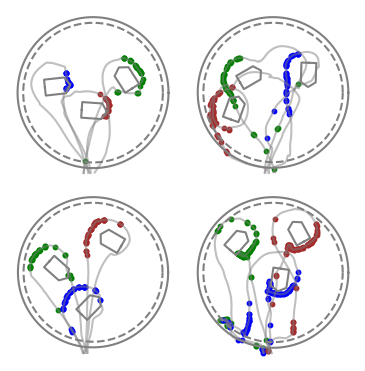

In [55]:
cellDict = {"light" :  {"cellIds":["mn9686-28102021-0107_178","mn9686-29102021-0106_230"],
                        "trialLists":([20,76,8],[4,5,34])},
           "dark" : {"cellIds": [ "mn9686-28102021-0107_31", "mn711-01022021-0107_75"],
                    "trialLists":([15,37,69],[11,37,59])}
           }
col=2
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(2, 2, figure=fig)

for j,light in enumerate(["light","dark"]):
    for i in range(2):
        axes = fig.add_subplot(gs[i, j]) # add an axes to the figure
        cluId = cellDict[light]["cellIds"][i]
        trialList=cellDict[light]["trialLists"][i]
        spikeOnPathSingleTrial(axes,cluId,trialList)


In [56]:
def exampleCell3(gs,cellId,light,trialList):
    gsPlan = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], height_ratios=[0.1,1]) # to get space for titles between rows
    cellIndex = pyrId[pyrId==cellId].index.item()
    #####################
    ####################
    #### first row
    ####################
    # 2D standard map
    ######################
    #######################
    gsMap = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gsPlan[1,0],width_ratios=[0.9,0.02]) # we spit into 11 to shift the arena left
    axes = fig.add_subplot(gsMap[0])
    spikeOnPathSingleTrial(axes,cellId,trialList)

    # Firing rate as a function of lever distance
    gsRD = gridspec.GridSpecFromSubplotSpec(1,1 , subplot_spec=gsPlan[1,1])
    ax = fig.add_subplot(gsRD[0])
    allCond="all_"+light
    plotRateLeverDistance(ax=ax,myLeverHistos=myLeverHistos,cellIndex=cellIndex,light=allCond,
                          title="",titleY=1.0,showXLabel=True)

    # Path matrix with distance from lever
    gsJ = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,2])
    ax = fig.add_subplot(gsJ[0])
    plotLeverIFRMatrix(ax,cellId,light,showXLabel=True,) 


dark mn711-01022021-0107_75 [11, 37, 59]


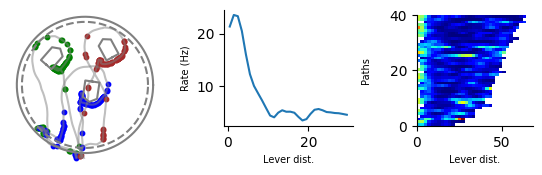

In [57]:
col=3
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

cellDict = {"light" :  {"cellIds":["mn9686-28102021-0107_178","mn9686-29102021-0106_230"],
                        "trialLists":([20,76,8],[4,5,34])},
           "dark" : {"cellIds": [ "mn9686-28102021-0107_31", "mn711-01022021-0107_75"],
                    "trialLists":([15,37,69],[11,37,59])}
           }
light = "dark"
cellId = cellDict[light]["cellIds"][1]
trialList = cellDict[light]["trialLists"][1]
print(light,cellId,trialList)

exampleCell3(gs,cellId,light,trialList)

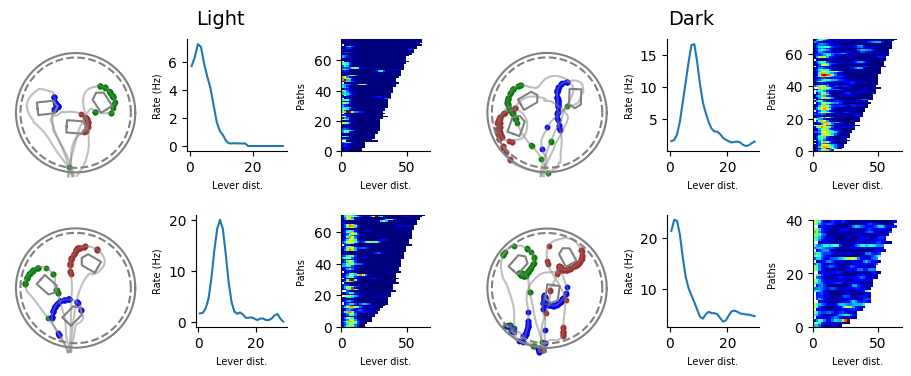

In [58]:
def exampleCell3Multi(gs):
   
    cellDict = {"light" :  {"cellIds":["mn9686-28102021-0107_178","mn9686-29102021-0106_230"],
                        "trialLists":([20,76,8],[4,5,34])},
               "dark" : {"cellIds": [ "mn9686-28102021-0107_31", "mn711-01022021-0107_75"],
                    "trialLists":([15,37,69],[11,37,59])}
               }
    
    gsPlan = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0], height_ratios=[0.05,1,1], width_ratios=[1,0.1,1]) # to get space for titles between rows
    
    gsLetter = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], width_ratios=[1,0.1,1]) # to get space for titles between rows
    
    for i, light in enumerate(["light","dark"]):
        # put the light and dark titles
        ax = fig.add_subplot(gsLetter[i*2])
        ax.text(0.5,1.5,light.capitalize(),fontsize=14,horizontalalignment='center')
        ax.axis("off")
    
        for j in range(2):        
            gsOneCell = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gsPlan[1+j,i*2]) # space for one cell
            
            cellId = cellDict[light]["cellIds"][j]
            trialList = cellDict[light]["trialLists"][j]
            #print(light,cellId,trialList)
            exampleCell3(gsOneCell,cellId,light,trialList)

col=5
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

exampleCell3Multi(gs)

/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/cardinal.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/bridge.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/lever.png


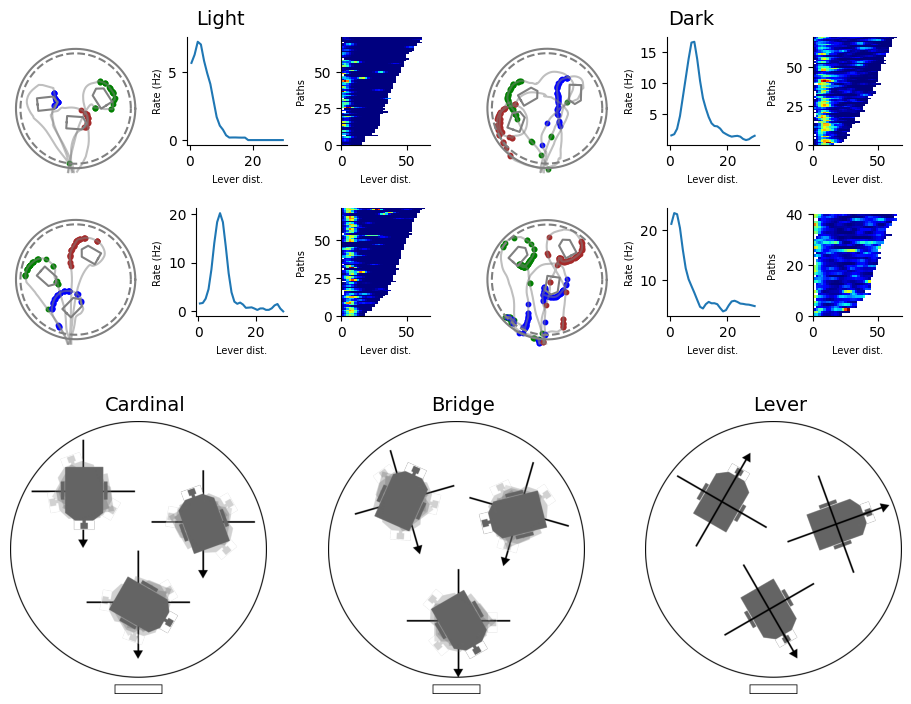

In [59]:
col=5
row=4
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

gsPlan = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec=gs[0], height_ratios=[0.1,1,1,1,1], width_ratios=[1,1]) # to get space for titles between rows

gsEx = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1:3,:]) # to get space for titles between rows
exampleCell3Multi(gsEx)

gsSch = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[3:,:]) # to get space for titles between rows
plotSchematic(gsSch)


In [60]:
def plotLeverCenter(gs,cellId,light):
    
    gsPlan = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[0], height_ratios=[0.1,1], width_ratios=[1,1,0.4,1,1,0.4,1,1]) # to get space for titles between rows
    cellIndex = pyrId[pyrId==cellId].index.item()
    allCond="all_"+light
    
    for i,(ref,refTitle) in  enumerate(zip(["none","bridge","lever"],["Cardinal","Bridge","Lever"])):
        
        # put the Cardinal,Bridge and Lever titles
       # ax = fig.add_subplot(gsLetter[i*2])
        #ax.text(0.5,1.3,light.capitalize(),fontsize=14,horizontalalignment='center')
        #ax.axis("off")
        
        
        ax = fig.add_subplot(gsPlan[1,i*3])
        rateType="map"
        plotMap(ax = ax, myMap = myLeverMaps[rateType][allCond][ref][cellIndex],
               title="{:.1f} Hz".format(np.nanmax(myLeverMaps[rateType][allCond][ref][cellIndex])),
               titleY=0.98)

        gsPolar = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,i*3+1])
        ax = fig.add_subplot(gsPolar[0],polar=True)

        rateType="angular"
        ax.plot(np.append(np.arange(-np.pi,np.pi,2*np.pi/36),-np.pi),
                np.append(myLeverMaps[rateType][allCond][ref][cellIndex],myLeverMaps[rateType][allCond][ref][cellIndex][0]))
        ax.set_xticklabels([])
        ax.set_title("{:.2f} vl, {:.1f} Hz".format(myLeverMapsStats[rateType][allCond][ref][cellIndex,2],myLeverMapsStats[rateType][allCond][ref][cellIndex,4]),y=0.98)
        ax.grid(True)

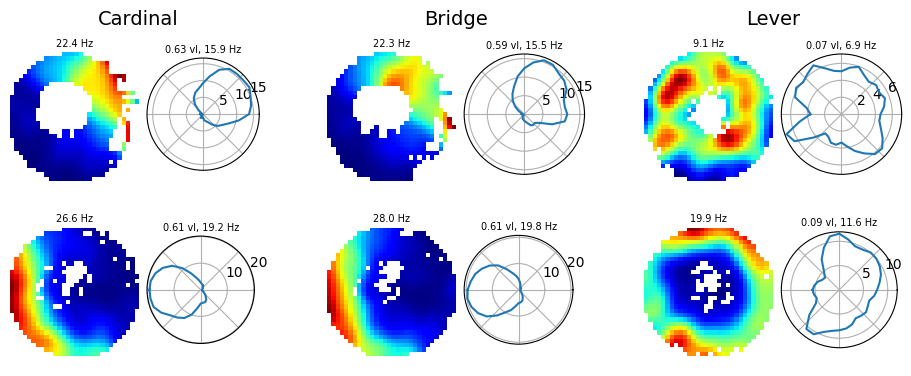

In [61]:
col=5
row=2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

def plotLeverCenterExamples(gs):
    gsPlan = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0],height_ratios=[0.05,1,1])
    gsLetter = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs[0], height_ratios=[1], width_ratios=[2,0.4,2,0.4,2]) 
    
    for i, name in enumerate(["Cardinal","Bridge", "Lever"]):
        ax = fig.add_subplot(gsLetter[i*2])
        ax.text(0.5,1.5,name,fontsize=14,horizontalalignment='center')
        ax.axis("off")
    
    
    cellDict = {"light" :  ["mn9686-28102021-0107_178","mn9686-29102021-0106_230", "mn3246-09042021-0106_218","mn9686-28102021-0107_10"],
               "dark" : [ "mn9686-28102021-0107_31", "mn711-01022021-0107_75","mn9686-27102021-0106_257", "mn711-02022021-0108_51"]}
    for j,light in enumerate(["light","dark"]):
        for i in range(1):
            gsOne = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[j+i+1])
            cellId = cellDict[light][i]
            plotLeverCenter(gsOne,cellId,light)

plotLeverCenterExamples(gs)

/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/cardinal.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/bridge.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/lever.png


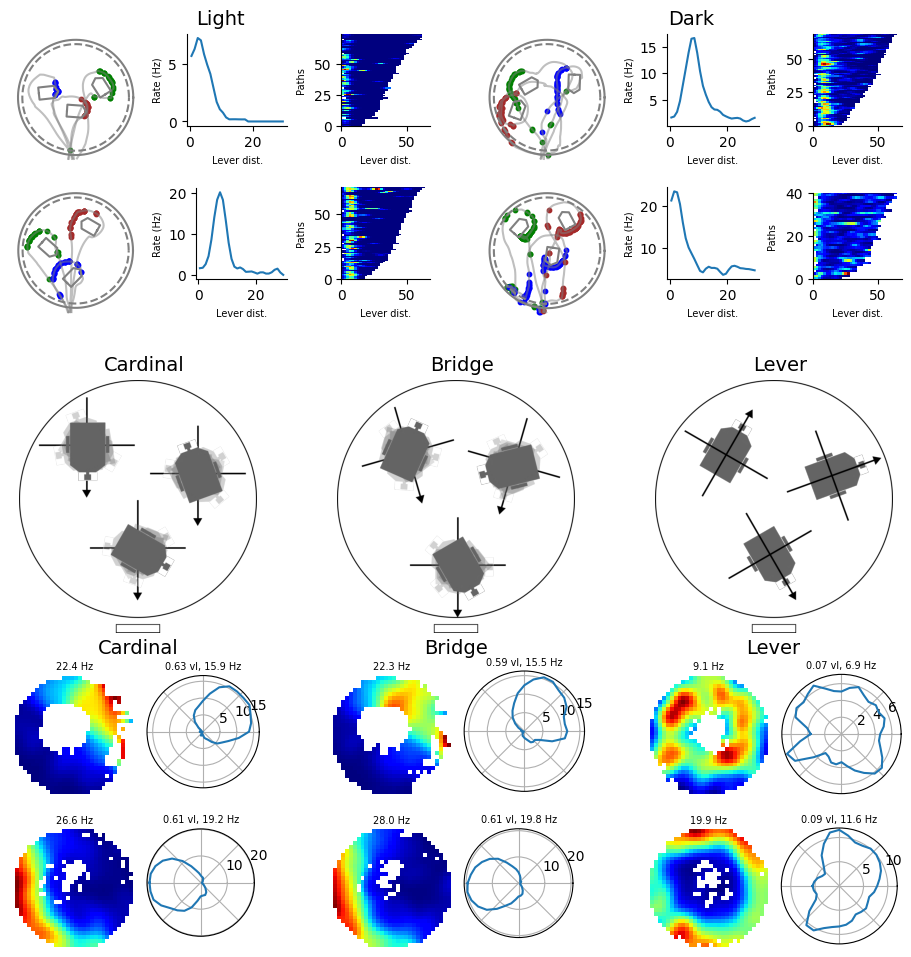

In [62]:
col=5
row=6.2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

gsPlan = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=gs[0], height_ratios=[0.1,1,1,1,1,1,1,1]) # to get space for titles between rows

gsEx = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1:3]) # to get space for titles between rows
exampleCell3Multi(gsEx)


gsSch = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[3:5]) # to get space for titles between rows
gsSch1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsSch[0]) # to get space for titles between rows
plotSchematic(gsSch1)

gsEx2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[5:7]) # to get space for titles between rows
plotLeverCenterExamples(gsEx2)


Dark 4.357000711820951e-06 115
Light 0.003096904604016111 113


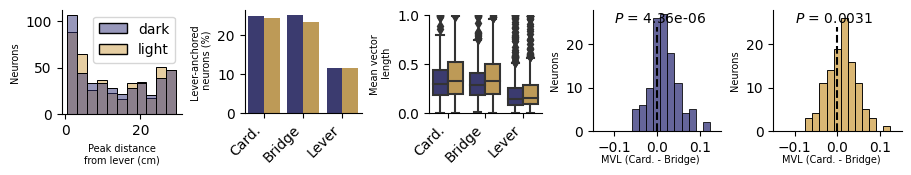

In [63]:
col=5
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig)


def plotStatsSimpler(gs):

    gsPlan = gridspec.GridSpecFromSubplotSpec(2,5, subplot_spec=gs[0],height_ratios=[0.1,1])


    gsDist = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,0])
    peakDistributionPlot(gsDist)
    
    gsSign = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,1])
    percentLeverAnchoredFields(gsSign,showLegend=False)
    
    gsMvl = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1,2])
    plotMapMvl(gsMvl,dfMvl)

    gsDiff = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gsPlan[1,3:])
    plotCardBridgeDiff(gsDiff,cardBri)


plotStatsSimpler(gs)

Prepare examples of neurons for our figure using the function developped above.

/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/cardinal.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/bridge.png
/home/maryam/repo/autopi_analysis/Jazi_et.al_2023/fig5/lever.png
Dark 4.357000711820951e-06 115
Light 0.003096904604016111 113


(-0.5, 1.5, 4.5, 26.5)

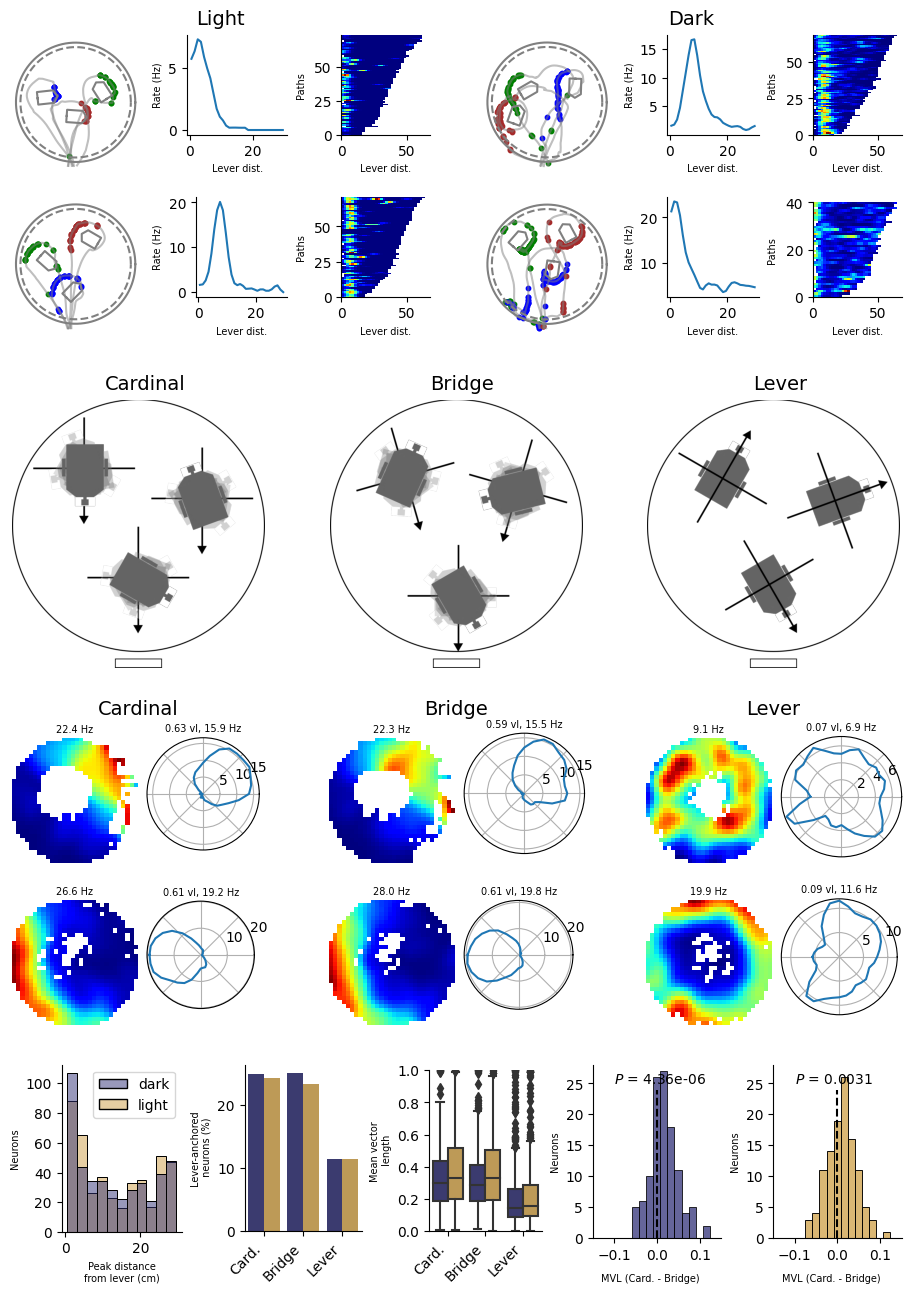

In [64]:
col=5
row=7.2
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(1, 1, figure=fig)

gsPlan = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=gs[0], height_ratios=[0.1,1,1,1,1,0.15,1,1,0.05,1.5]) # to get space for titles between rows

gsEx = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[1:3]) # to get space for titles between rows
exampleCell3Multi(gsEx)

gsSch = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[3:5]) # to get space for titles between rows
gsSch1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsSch[0]) # to get space for titles between rows
plotSchematic(gsSch1)

gsEx2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[6:8]) # to get space for titles between rows
plotLeverCenterExamples(gsEx2)

gsStats = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsPlan[9:]) # to get space for titles between rows
plotStatsSimpler(gsStats)

ax.axis("off")
